# Création d’un outil d’estimation immobilière basé sur le machine learning : Cas du marché marocain

# Importation des bibliothéque

In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# encoder /echelle de variable
from sklearn.model_selection import train_test_split ,cross_val_score ,GridSearchCV

from sklearn.preprocessing import LabelEncoder ,MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from sklearn.ensemble import RandomForestRegressor ,GradientBoostingRegressor
from sklearn.svm import SVR






# Partie 1: Chargement des données

In [342]:
#1-Importer les données à l’aide de pandas
df = pd.read_csv('appartements-data.csv')

#2-Vérifier le type et la structure des colonnes (df.info() et df.head()).
df.info()#permet de donne les collone exixst et aussi le type de chaque collone
#print(df.head()) #permet de donner les 5 premier ligne de tableau

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1772 non-null   object 
 1   price         1490 non-null   object 
 2   city_name     1772 non-null   object 
 3   salon         1620 non-null   float64
 4   nb_rooms      1490 non-null   float64
 5   nb_baths      1480 non-null   float64
 6   surface_area  1742 non-null   float64
 7   equipment     1402 non-null   object 
 8   link          1773 non-null   object 
dtypes: float64(4), object(5)
memory usage: 124.8+ KB


# Partie 2: Analyse exploratoire des données (EDA)

In [343]:
#** 1-Comprendre la structure générale du jeu de données (types, dimensions, aperçus).

#^^ type deux méthodes :
print("le types des données est :")
print(df.dtypes)
print(f"**** le type de salon est : {df['salon'].dtypes} *****")

#^^ pour les dimention de data

print(f"**** la dimention des données est : {df.shape} *****")

#^^ pour apercus just les nom des columns 
print(f"**** lles nom des columns : {list(df.columns)} ***** ")

#2-Identifier les valeurs manquantes et les doublons.

print(f"les Valeurs manquantes sont :{df.isna().sum()}")
print(f"les Valeurs doublent  sont : {df.duplicated().sum()}")


le types des données est :
title            object
price            object
city_name        object
salon           float64
nb_rooms        float64
nb_baths        float64
surface_area    float64
equipment        object
link             object
dtype: object
**** le type de salon est : float64 *****
**** la dimention des données est : (1773, 9) *****
**** lles nom des columns : ['title', 'price', 'city_name', 'salon', 'nb_rooms', 'nb_baths', 'surface_area', 'equipment', 'link'] ***** 
les Valeurs manquantes sont :title             1
price           283
city_name         1
salon           153
nb_rooms        283
nb_baths        293
surface_area     31
equipment       371
link              0
dtype: int64
les Valeurs doublent  sont : 41


['salon', 'nb_rooms', 'nb_baths', 'surface_area']
*************** statistiques ************
             salon     nb_rooms     nb_baths   surface_area
count  1620.000000  1490.000000  1480.000000    1742.000000
mean      1.267284     2.379195     2.307432     174.933410
std       0.557539     0.667159     7.629128    2969.500693
min       0.000000     1.000000     0.000000       1.000000
25%       1.000000     2.000000     1.000000      71.000000
50%       1.000000     2.000000     2.000000      89.000000
75%       1.000000     3.000000     2.000000     114.750000
max       8.000000     7.000000   134.000000  123456.000000
** matrice de corrélation
                 salon  nb_rooms  nb_baths  surface_area
salon         1.000000  0.304830  0.020866     -0.002076
nb_rooms      0.304830  1.000000  0.047500      0.618032
nb_baths      0.020866  0.047500  1.000000      0.040730
surface_area -0.002076  0.618032  0.040730      1.000000


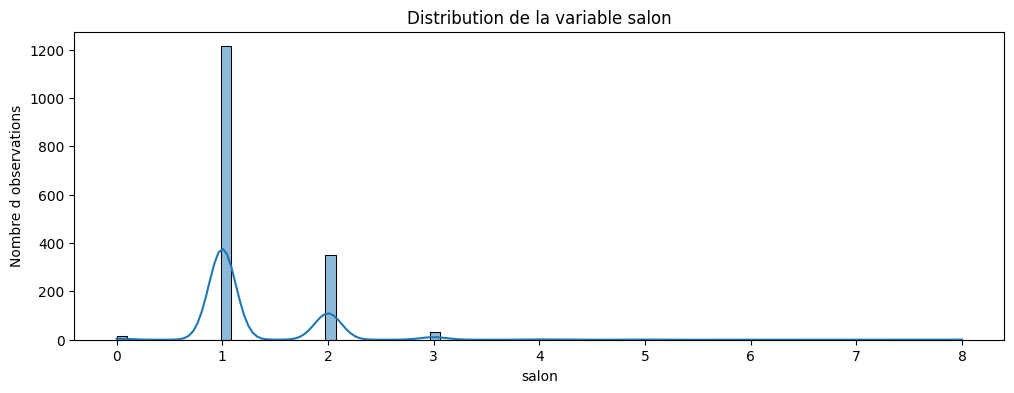

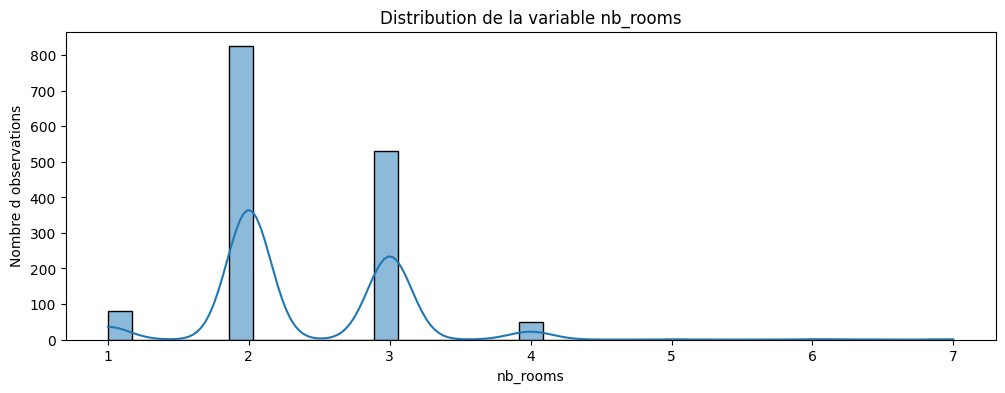

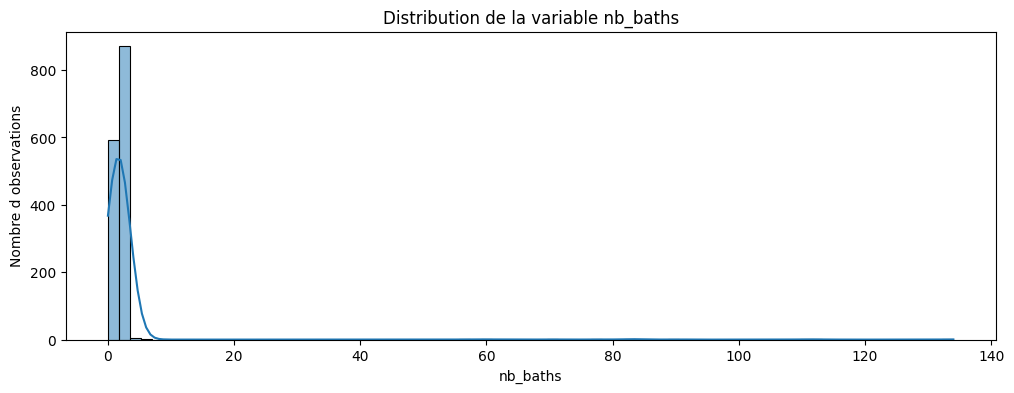

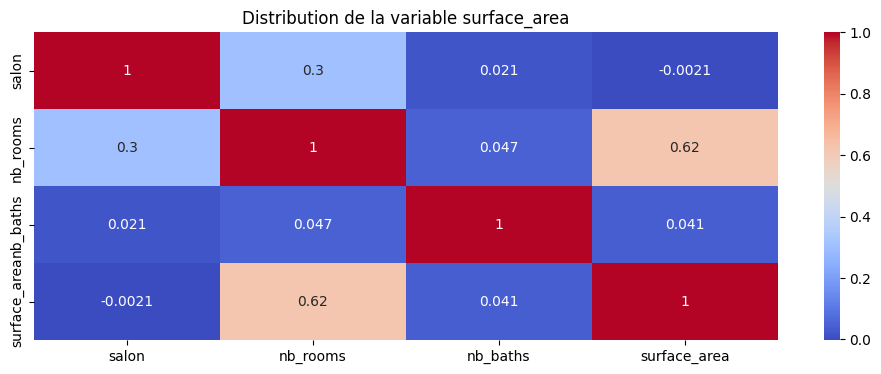

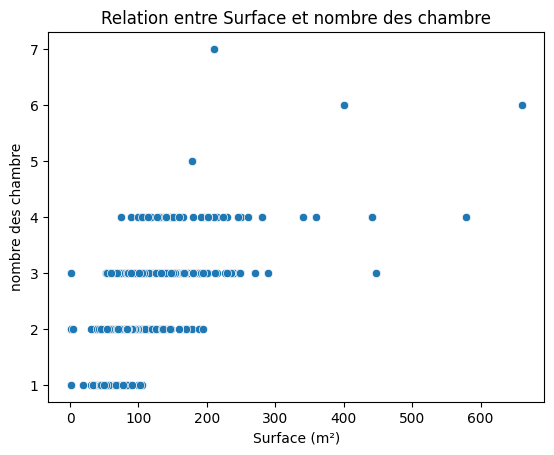

In [344]:
#**
#** 3-Analyser la distribution des variables numériques.
#^ 1- Lister toutes les colonnes numériques (donc la separation des data )

df_numeric = df.select_dtypes(include=['number']).columns.tolist()
print(df_numeric)

#^ 2- Pour chaque variable numérique il faut calculer (min - max - Moyenne -median )

# for data in df_numeric :
    
#     print(f"la moyenne  de {data} est : {df[data].mean():.2f}")
#     print(f"le mediane  de {data} est : {df[data].median()}")
#     print(f"le min  de {data} est : {df[data].min()}")
#     print(f"le max  de {data} est : {df[data].max()}")
print("*************** statistiques ************")
print(df.describe())

#^ 3- Distribution visuelle
for data in df_numeric:

    plt.figure(figsize=(12, 4))
    #trace un histogramme
    sns.histplot(df[data], kde=True)
    plt.title(f'Distribution de la variable {data}')
    plt.xlabel(data)
    plt.ylabel('Nombre d observations')
    # plt.show()

#** Étudier les relations entre variables à l’aide de matrices de corrélation et de visualisations
#les valeur entre -1 et 1
corr_matrix = df[df_numeric].corr()
print("** matrice de corrélation")
print(corr_matrix)


# Visualisation : heatmap de corrélation
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# #Scatterplot entre deux variables importantes (exemple : surface vs prix)
sns.scatterplot(x=df['surface_area'], y=df['nb_rooms'])

plt.title('Relation entre Surface et nombre des chambre')
plt.xlabel('Surface (m²)')
plt.ylabel('nombre des chambre')
plt.show()

# partie 3: Prétraitement des données

In [345]:
#
#** 1- Nettoyage & Transformation: 

#^^Extraire les équipements (equipment) dans des colonnes booléennes à l’aide de str.get_dummies().
equipment_bool = df["equipment"].str.get_dummies(sep="/")

df = pd.concat([df, equipment_bool], axis=1)

#^^Convertir la colonne price (de type objet) en type float, en supprimant les caractères non numériques.
# df['price'] = df['price'].str.replace('DH', '').str.replace(' ', '')

df['price'] = df['price'].str.replace(r'[^\d]', '', regex=True)
df['price'] = df['price'].astype(float)
df["price"]
#^^  Supprimer les colonnes inutiles telles que equipment et link.
df = df.drop('link', axis=1)
df = df.drop('equipment', axis=1)

print(list(df.columns))

#^^Traitement de la colonne city_name. Uniformiser les noms de villes : convertir les noms en arabe vers leur équivalent français.
traduction_villes = {
    'الرباط': 'Rabat',
    'الدار البيضاء': 'Casablanca',
    'فاس': 'Fès',
    'مراكش': 'Marrakech',
    'أكادير': 'Agadir'
}
print(traduction_villes)
df['city_name'] = df['city_name'].replace(traduction_villes)

print(df["city_name"][1399])
#^^Remplacer les valeurs manquantes dans city_name par "Unknown".
df['city_name'] = df['city_name'].fillna('Unknown')



['title', 'price', 'city_name', 'salon', 'nb_rooms', 'nb_baths', 'surface_area', 'Ascenseur', 'Balcon', 'Chauffage', 'Climatisation', 'Concierge', 'Cuisine Équipée', 'Duplex', 'Meublé', 'Parking', 'Sécurité', 'Terrasse']
{'الرباط': 'Rabat', 'الدار البيضاء': 'Casablanca', 'فاس': 'Fès', 'مراكش': 'Marrakech', 'أكادير': 'Agadir'}
Agadir


In [346]:
#
#** 2- Gestion des valeurs manquantes:

#^^Pour les colonnes numériques : imputer les valeurs manquantes par la médiane.
df_numeric = df.select_dtypes(include=['number']).columns.to_list()
print(f"les valeur numeriques sont :{df_numeric}")

print(df.shape)
for val in df_numeric:
    if val =="price":
        df = df.dropna(subset=['price'])
    else:
        median = df[val].median()
        df[val] = df[val].fillna(median)
        
print(df.shape)

#^^Pour les colonnes catégorielles (chaînes de caractères) : imputer avec "Unknown".
df_categorie = df.select_dtypes(include=['object']).columns.to_list()
print(f"les valeur categorial sont :{df_categorie}")

for val in df_categorie :
    df[val]=df[val].fillna("unknown")


les valeur numeriques sont :['price', 'salon', 'nb_rooms', 'nb_baths', 'surface_area', 'Ascenseur', 'Balcon', 'Chauffage', 'Climatisation', 'Concierge', 'Cuisine Équipée', 'Duplex', 'Meublé', 'Parking', 'Sécurité', 'Terrasse']
(1773, 18)
(1490, 18)
les valeur categorial sont :['title', 'city_name']


  - Lignes supprimées : 96
Nombre d'outlier final price : 0
  - Lignes supprimées : 290
Nombre d'outlier final salon : 0
Nombre d'outlier final nb_rooms : 2
Nombre d'outlier final nb_baths : 12
Nombre d'outlier final surface_area : 29
Nombre d'outlier final Ascenseur : 0
Nombre d'outlier final Balcon : 0
Nombre d'outlier final Chauffage : 168
Nombre d'outlier final Climatisation : 0
Nombre d'outlier final Concierge : 0
Nombre d'outlier final Cuisine Équipée : 0
Nombre d'outlier final Duplex : 20
Nombre d'outlier final Meublé : 98
Nombre d'outlier final Parking : 0
Nombre d'outlier final Sécurité : 0
Nombre d'outlier final Terrasse : 0


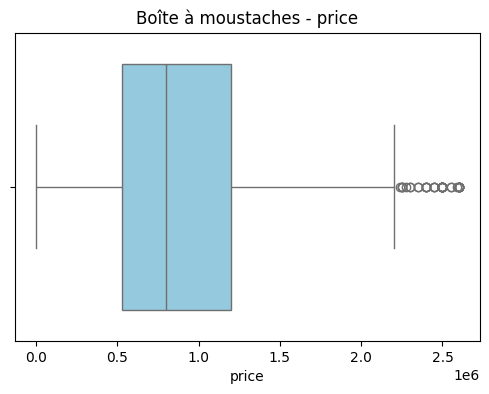

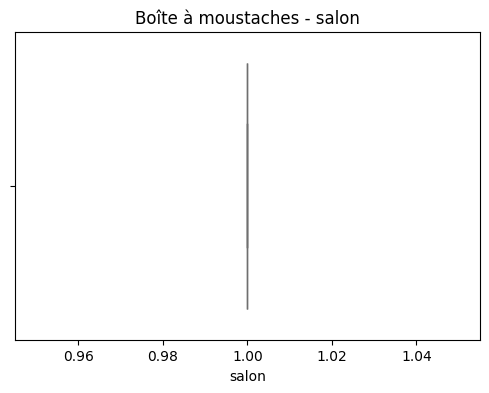

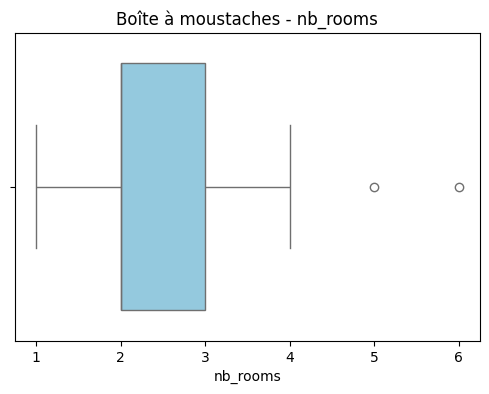

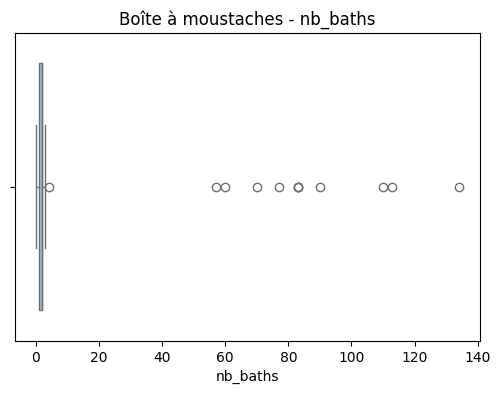

(1104, 18)


In [347]:
#
# ** 3- Détection et suppression des valeurs aberrantes:

#^^ Utiliser des méthodes statistiques (boîtes à moustaches, z-score, IQR) pour détecter les outliers.
# for val in df_numeric:
    
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x=df[val], color='skyblue')
#     plt.title(f'Boîte à moustaches - {val}')
#     plt.show()
#pour les outliers 
for val in df_numeric:
    Q1 = df[val].quantile(0.25)
    Q3 = df[val].quantile(0.75)
    IQR = Q3 - Q1
 
    min_point = Q1 - 1.5 * IQR
    max_point = Q3 + 1.5 * IQR


    outliers = (df[val] < min_point) | (df[val] > max_point) #true false
    nombre_outliers = outliers.sum()
    #print(f"Nombre d'outliers pour {val} : {nombre_outliers}")
 

    if val == 'price' or val == 'salon':  
        
        df_avant = df.shape[0]
        df = df[~outliers].copy()
        df_apres = df.shape[0]
        print(f"  - Lignes supprimées : {df_avant - df_apres}")

   
    # else:
    #     median_val = df[val].median()
    #     df.loc[outliers, val] = median_val

            
    outliers = (df[val] < min_point) | (df[val] > max_point) #true false
    nombre_outliers = outliers.sum()
    print(f"Nombre d'outlier final {val} : {nombre_outliers}")
        
           
for i in range(4):
    val = df_numeric[i]
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[val], color='skyblue')
    plt.title(f'Boîte à moustaches - {val}')
    plt.show()           
    
print(df.shape)


In [348]:
# 
#** 4- Encodage des variables catégorielles:

#^^ Appliquer un Label Encoding selon le modèle utilisé, en particulier sur city_name.
encoder = LabelEncoder()
df['city_name'] = encoder.fit_transform(df['city_name'])
df['city_name'].head(10)


0     11
1     11
2     13
3     11
6     27
7     11
8      4
9     11
10     7
11    26
Name: city_name, dtype: int64

In [349]:
#
# ** 5- Mise à l’échelle des variables:

#^^Appliquer une normalisation (MinMaxScaler) ou une standardisation (StandardScaler) sur les variables numériques pour harmoniser les échelles.
#outliers :oui : StandardScaler ,Non :MinMaxScaler
X = df[df_numeric]

print("avec Minscaller")
scaler = MinMaxScaler()  # Par défaut : range=[0,1]
normalisation = scaler.fit_transform(X)

# Convertir en DataFrame pour mieux visualiser
normalisation = pd.DataFrame(normalisation, columns=df_numeric)
normalisation.head()

# print("avec standael")
# X = df[df_numeric]
# scaler = StandardScaler()
# normalisation = scaler.fit_transform(X)
# normalisation = pd.DataFrame(normalisation, columns=df_numeric)
# print(normalisation.head(10))

avec Minscaller


,price,salon,nb_rooms,nb_baths,surface_area,Ascenseur,Balcon,Chauffage,Climatisation,Concierge,Cuisine Équipée,Duplex,Meublé,Parking,Sécurité,Terrasse
0,0.769228,0.0,0.2,0.014925,0.418546,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.459608,0.0,0.2,0.014925,0.243108,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.519224,0.0,0.2,0.014925,0.200501,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,0.346145,0.0,0.0,0.007463,0.137845,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
4,0.292298,0.0,0.4,0.022388,0.243108,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0


price              1.000000
surface_area       0.511684
Ascenseur          0.323432
nb_rooms           0.264582
Parking            0.214087
Terrasse           0.208398
Climatisation      0.203848
Concierge          0.172588
Balcon             0.144893
Chauffage          0.142808
Sécurité           0.093939
Cuisine Équipée    0.081524
Meublé             0.067433
Duplex             0.017307
nb_baths           0.009231
salon                   NaN
Name: price, dtype: float64


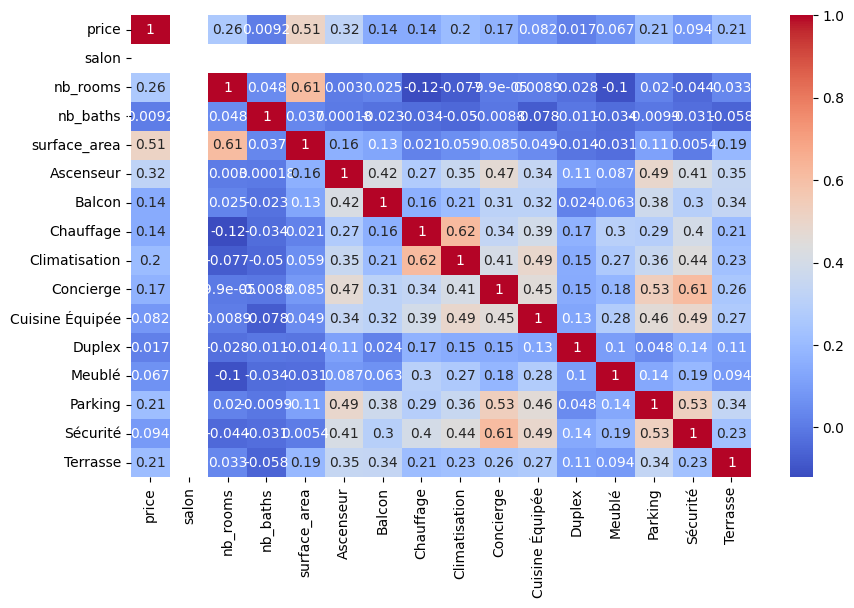

Variables sélectionnées: ['surface_area', 'Ascenseur', 'nb_rooms', 'Parking', 'Terrasse', 'Climatisation', 'Concierge']


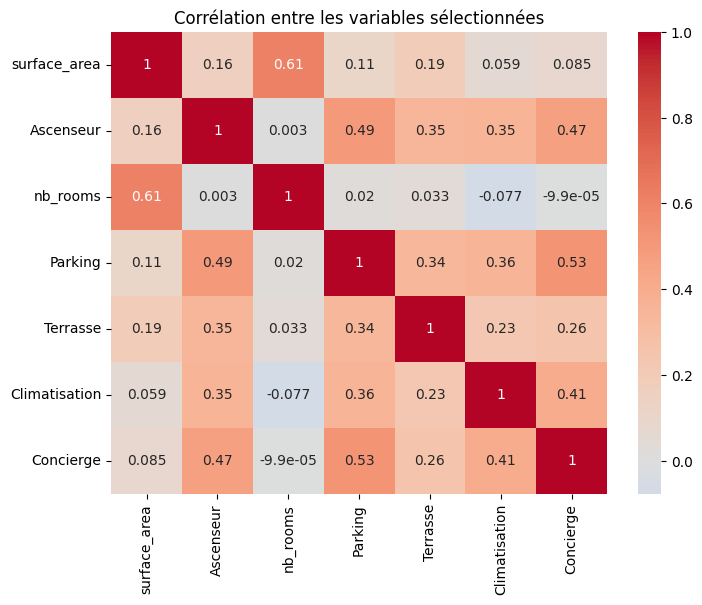

In [350]:
#
# ** 6-Sélection des variables explicatives:

#^^ Choisir les variables numériques corrélées au prix (corr > 0.15).

prix_correlation = normalisation.corr()["price"].abs().sort_values(ascending=False)
print(prix_correlation)


plt.figure(figsize=(10, 6))
sns.heatmap(normalisation.corr(), annot=True, cmap="coolwarm")
plt.show()


selected_features = prix_correlation[prix_correlation > 0.15].index.tolist()
selected_features.remove("price")  
print("Variables sélectionnées:", selected_features)

#^^ Vérifier que les variables choisies ne sont pas fortement corrélées entre elles pour éviter la redondance.

correlation_selected = normalisation[selected_features].corr()

# Afficher la matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_selected, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélation entre les variables sélectionnées")
plt.show()

for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        corr_value = correlation_selected.iloc[i, j]
        if abs(corr_value) > 0.8:
            print(f"Attention: {selected_features[i]} et {selected_features[j]} sont fortement corrélées: {corr_value:.3f}")

In [351]:
#
# **7- Séparation des données

# Définir la variable cible et les variables explicatives
y = normalisation["price"]
X = normalisation[selected_features]

# Diviser en ensemble d'entraînement et de test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Taille ensemble d'entraînement: {X_train.shape}")
print(f"Taille ensemble de test: {X_test.shape}")
X_train

Taille ensemble d'entraînement: (883, 7)
Taille ensemble de test: (221, 7)


,surface_area,Ascenseur,nb_rooms,Parking,Terrasse,Climatisation,Concierge
1006,0.187970,1.0,0.2,0.0,0.0,1.0,0.0
256,0.085213,0.0,0.2,0.0,0.0,0.0,0.0
290,0.137845,0.0,0.2,0.0,0.0,0.0,0.0
292,0.145363,0.0,0.2,0.0,1.0,0.0,0.0
2,0.200501,1.0,0.2,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
466,0.200501,1.0,0.2,1.0,1.0,1.0,1.0
121,0.270677,1.0,0.4,1.0,1.0,0.0,1.0
1044,0.107769,1.0,0.0,1.0,0.0,1.0,0.0
1095,0.132832,0.0,0.2,1.0,0.0,0.0,0.0


# Entraînement des modèles de régression

# 1-Régression Linéaire

In [352]:

# 1. Entraînement du modèle
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# 2. Prédictions
y_pred = model_lr.predict(X_test)

# 3. Évaluation du modèle
# MSE/RMSE : Mesurent l'erreur moyenne (plus c'est bas, mieux c'est)
# MAE : Erreur absolue moyenne (plus facile à interpréter)
# R² : Pourcentage de variance expliquée 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Évaluation du modèle :")
print(f"MSE : {mse:.2f} ,RMSE : {rmse:.2f} ,MAE : {mae:.2f} ,R² Score : {r2:.2f}")


# 4. Validation croisée 
cv_scores = cross_val_score(model_lr, X, y, cv=5, scoring='r2')
print("\n Validation croisée :")
print(f"R² moyen : {cv_scores.mean():.2f} ,Écart-type : {cv_scores.std():.2f}")

# 5. Optimisation des hyperparamètres (pour Ridge comme exemple)
from sklearn.linear_model import Ridge

param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

ridge = Ridge()
grid = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)

print("\nMeilleurs hyperparamètres pour Ridge :")
print(f"alpha : {grid.best_params_['alpha']}, Meilleur R² (CV) : {grid.best_score_:.2f}")



Évaluation du modèle :
MSE : 0.03 ,RMSE : 0.17 ,MAE : 0.12 ,R² Score : 0.34

 Validation croisée :
R² moyen : 0.28 ,Écart-type : 0.08

Meilleurs hyperparamètres pour Ridge :
alpha : 0.1, Meilleur R² (CV) : 0.30


# 2- Random Forest


In [353]:


# 1. Entraînement du modèle Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# 2. Prédictions
y_pred_rf = rf.predict(X_test)

# 3. Évaluation du modèle
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Évaluation du modèle Random Forest :")
print(f"MSE : {mse_rf:.2f} ,RMSE : {rmse_rf:.2f} ,MAE : {mae_rf:.2f} ,R² Score : {r2_rf:.2f}")


# 4. Validation croisée 
cv_scores_rf = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("\nValidation croisée Random Forest :")
print(f"R² moyen : {cv_scores_rf.mean():.2f} , Écart-type : {cv_scores_rf.std():.2f}")


# 5. Optimisation des hyperparamètres
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("\nMeilleurs hyperparamètres Random Forest :")
print(f"{grid_rf.best_params_} , Meilleur R² (CV) : {grid_rf.best_score_:.2f}")



Évaluation du modèle Random Forest :
MSE : 0.03 ,RMSE : 0.16 ,MAE : 0.12 ,R² Score : 0.42

Validation croisée Random Forest :
R² moyen : 0.25 , Écart-type : 0.06

Meilleurs hyperparamètres Random Forest :
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50} , Meilleur R² (CV) : 0.33


# 3- Modéle SvR


In [354]:

# 1. Entraînement du modèle SVR
svr = SVR()
svr.fit(X_train, y_train)

# 2. Prédictions
y_pred_svr = svr.predict(X_test)

# 3. Évaluation du modèle
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("Évaluation du modèle SVR :")
print(f"MSE : {mse_svr:.2f} , RMSE : {rmse_svr:.2f} , MAE : {mae_svr:.2f} ,R² Score : {r2_svr:.2f}")

# 4. Validation croisée 
cv_scores_svr = cross_val_score(svr, X, y, cv=5, scoring='r2')
print("\nValidation croisée SVR :")
print(f"R² moyen : {cv_scores_svr.mean():.2f} ,Écart-type : {cv_scores_svr.std():.2f}")

# 5. Optimisation des hyperparamètres
param_grid_svr = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'epsilon': [0.1, 0.2, 0.5]
}

grid_svr = GridSearchCV(SVR(), param_grid_svr, cv=3, scoring='r2', n_jobs=-1)
grid_svr.fit(X_train, y_train)

print("\nMeilleurs hyperparamètres SVR :")
print(f" {grid_svr.best_params_}")
print(f"Meilleur R² (CV) : {grid_svr.best_score_:.2f}")


Évaluation du modèle SVR :
MSE : 0.03 , RMSE : 0.18 , MAE : 0.13 ,R² Score : 0.29

Validation croisée SVR :
R² moyen : 0.28 ,Écart-type : 0.07

Meilleurs hyperparamètres SVR :
 {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
Meilleur R² (CV) : 0.34


# 4-Gradient Boosting

In [355]:

# 1. Entraînement du modèle Gradient Boosting
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# 2. Prédictions
y_pred_gbr = gbr.predict(X_test)

# 3. Évaluation du modèle
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("Évaluation du modèle Gradient Boosting :")
print(f"MSE : {mse_gbr:.2f} , RMSE : {rmse_gbr:.2f} , MAE : {mae_gbr:.2f} ,R² Score : {r2_gbr:.2f}")


# 4. Validation croisée 
cv_scores_gbr = cross_val_score(gbr, X, y, cv=10, scoring='r2')
print("\nValidation croisée Gradient Boosting :")
print(f"R² moyen : {cv_scores_gbr.mean():.2f} , Écart-type : {cv_scores_gbr.std():.2f}")

# 5. Optimisation des hyperparamètres
param_grid_gbr = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

grid_gbr = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gbr, cv=3, scoring='r2', n_jobs=-1)
grid_gbr.fit(X_train, y_train)

print("\nMeilleurs hyperparamètres Gradient Boosting :")
print(f"{grid_gbr.best_params_} , Meilleur R² (CV) : {grid_gbr.best_score_:.2f}")



Évaluation du modèle Gradient Boosting :
MSE : 0.03 , RMSE : 0.17 , MAE : 0.12 ,R² Score : 0.37

Validation croisée Gradient Boosting :
R² moyen : 0.32 , Écart-type : 0.08

Meilleurs hyperparamètres Gradient Boosting :
{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100} , Meilleur R² (CV) : 0.34
